In [34]:
#================================================
# DATA
#================================================

import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# cria ou liga se já existir:
#con = duckdb.connect("movielens100K.duckdb")
#criamos um ficheiro duckdb diferent porque se calhar nem todas as tabelas irão ser juntas às tabelas do movielens
con = duckdb.connect("imdb_dataset.duckdb")

In [22]:
IMDB_DIR = Path("..") / "data" / "Imdb"
IMDB_DIR

WindowsPath('../data/Imdb')

### Análise ficheiro 1: "name.basics.tsv"

In [35]:
con.sql(f"""
CREATE OR REPLACE TABLE imdb_name_basics AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "name.basics.tsv"}', delim='\t', header=TRUE)
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [36]:
con.sql("PRAGMA table_info('imdb_name_basics')").df()

,cid,name,type,notnull,dflt_value,pk
0,0,nconst,VARCHAR,False,None,False
1,1,primaryName,VARCHAR,False,None,False
2,2,birthYear,VARCHAR,False,None,False
3,3,deathYear,VARCHAR,False,None,False
4,4,primaryProfession,VARCHAR,False,None,False
5,5,knownForTitles,VARCHAR,False,None,False


In [37]:
con.sql("SELECT * FROM imdb_name_basics LIMIT 10").df()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0025164"
1,nm0000002,Lauren Bacall,1924,2014,"actress,miscellaneous,soundtrack","tt0037382,tt0075213,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0083922,tt0050976"
5,nm0000006,Ingrid Bergman,1915,1982,"actress,producer,soundtrack","tt0034583,tt0038109,tt0036855,tt0038787"
6,nm0000007,Humphrey Bogart,1899,1957,"actor,producer,miscellaneous","tt0034583,tt0043265,tt0037382,tt0042593"
7,nm0000008,Marlon Brando,1924,2004,"actor,director,writer","tt0078788,tt0068646,tt0047296,tt0070849"
8,nm0000009,Richard Burton,1925,1984,"actor,producer,director","tt0061184,tt0087803,tt0057877,tt0059749"
9,nm0000010,James Cagney,1899,1986,"actor,director,producer","tt0029870,tt0031867,tt0042041,tt0034236"


In [38]:
#contagem do numero de primaryNames existem na tabela.
con.sql("""
SELECT COUNT(DISTINCT primaryname) AS total_nomes
FROM imdb_name_basics
""").df()


,total_nomes
0,11348597


In [39]:
#contagem do numero de profissões distantas existes na tabela.
con.sql("""
SELECT COUNT(DISTINCT profession) AS total_profissoes_distintas
FROM (
    SELECT unnest(string_split(primaryProfession, ',')) AS profession
    FROM imdb_name_basics
)
""").df()


,total_profissoes_distintas
0,47


In [40]:
#Numero de diferentes profissões e a contagem do numero de cada uma delas
con.sql("""
SELECT
    profession,
    COUNT(*) AS total
FROM (
    SELECT unnest(string_split(primaryProfession, ',')) AS profession
    FROM imdb_name_basics
)
GROUP BY profession
ORDER BY total DESC
""").df()

,profession,total
0,actor,3412934
1,\N,2956227
2,actress,2062425
3,miscellaneous,1338806
4,producer,1309116
5,writer,981441
6,camera_department,870867
7,director,802905
8,art_department,486831
9,cinematographer,430325


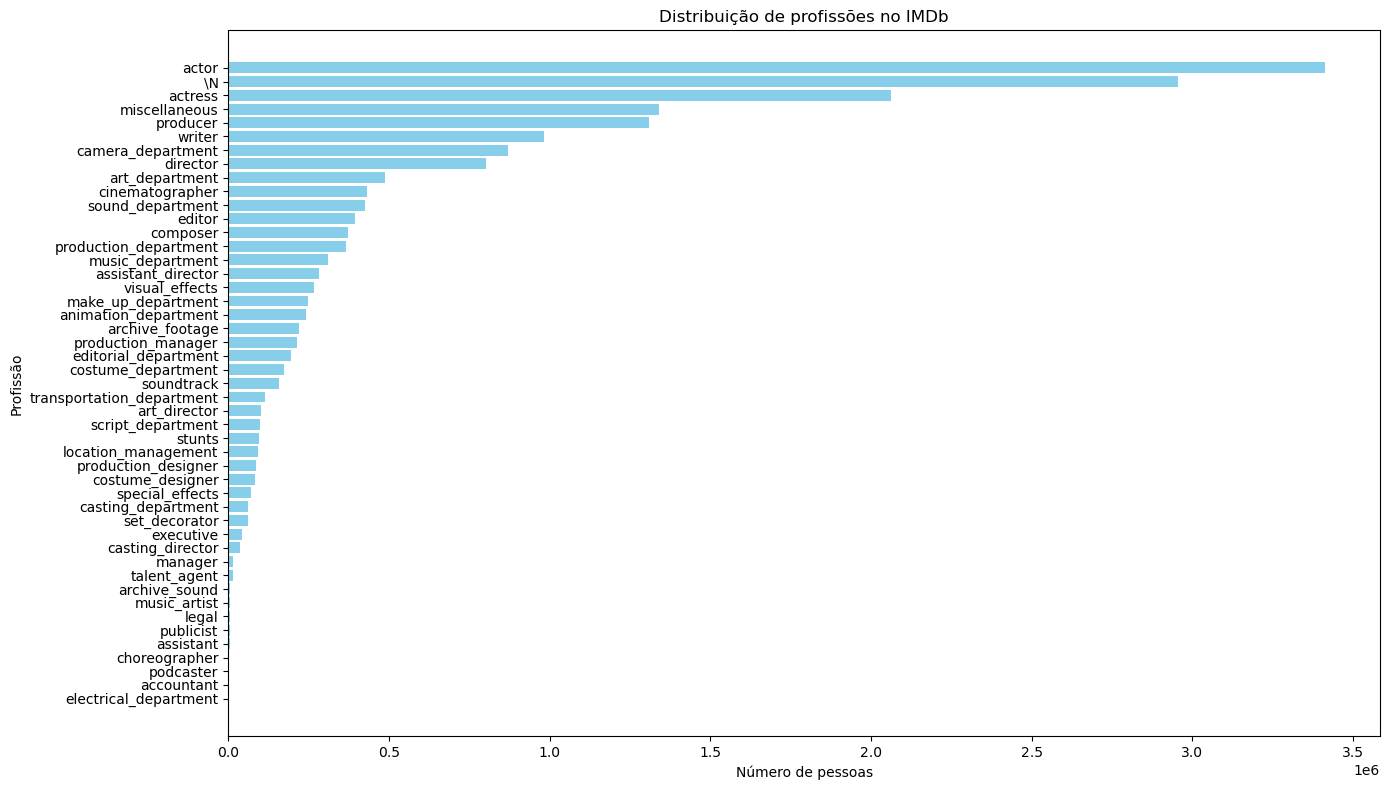

In [42]:
import matplotlib.pyplot as plt

# obter dados da query
df_prof = con.sql("""
SELECT
    profession,
    COUNT(*) AS total
FROM (
    SELECT unnest(string_split(primaryProfession, ',')) AS profession
    FROM imdb_name_basics
)
GROUP BY profession
ORDER BY total DESC
""").df()

# gráfico
plt.figure(figsize=(14, 8))
plt.barh(df_prof["profession"], df_prof["total"], color="skyblue")
plt.xlabel("Número de pessoas")
plt.ylabel("Profissão")
plt.title("Distribuição de profissões no IMDb")
plt.gca().invert_yaxis()  # para mostrar a profissão mais comum no topo
plt.tight_layout()
plt.show()


### Análise ficheiro 2: "title.akas.tsv"

In [52]:
con.sql(f"""
CREATE OR REPLACE TABLE imdb_title_akas AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.akas.tsv"}', delim='\t', header=TRUE)
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [53]:
con.sql("PRAGMA table_info('imdb_title_akas')").df()

,cid,name,type,notnull,dflt_value,pk
0,0,titleId,VARCHAR,False,None,False
1,1,ordering,BIGINT,False,None,False
2,2,title,VARCHAR,False,None,False
3,3,region,VARCHAR,False,None,False
4,4,language,VARCHAR,False,None,False
5,5,types,VARCHAR,False,None,False
6,6,attributes,VARCHAR,False,None,False
7,7,isOriginalTitle,BIGINT,False,None,False


In [54]:
con.sql("SELECT * FROM imdb_title_akas LIMIT 10").df()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Carmencita,\N,\N,original,\N,1
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita,US,\N,imdbDisplay,\N,0
3,tt0000001,4,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
4,tt0000001,5,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
5,tt0000001,6,Карменсита,RU,\N,imdbDisplay,\N,0
6,tt0000001,7,Карменсіта,UA,\N,imdbDisplay,\N,0
7,tt0000001,8,カルメンチータ,JP,ja,imdbDisplay,\N,0
8,tt0000002,1,Le clown et ses chiens,\N,\N,original,\N,1
9,tt0000002,2,A bohóc és kutyái,HU,\N,imdbDisplay,\N,0


In [ ]:
#quantos filmes tem esta database?
con.sql("""
SELECT COUNT(DISTINCT titleId) AS total_titulos
FROM imdb_title_akas
""").df()
#12 milhões 44 mil e 167 titulos nesta tabela.


,total_titulos
0,12044167


In [ ]:
#quantos filmes tem esta database?
con.sql("""
SELECT COUNT(titleId) AS total_titulos
FROM imdb_title_akas
""").df()
#Esta tabea tem 53 milhões e 893 mil e 147 titulos nesta tabela.

,total_titulos
0,53893147


### Análise ficheiro 3: "title.basics.tsv"

In [45]:
con.sql(f"""
CREATE OR REPLACE TABLE imdb_title_basics AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.basics.tsv"}', delim='\t', header=TRUE)
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [46]:
con.sql("PRAGMA table_info('imdb_title_basics')").df()

,cid,name,type,notnull,dflt_value,pk
0,0,tconst,VARCHAR,False,None,False
1,1,titleType,VARCHAR,False,None,False
2,2,primaryTitle,VARCHAR,False,None,False
3,3,originalTitle,VARCHAR,False,None,False
4,4,isAdult,BIGINT,False,None,False
5,5,startYear,VARCHAR,False,None,False
6,6,endYear,VARCHAR,False,None,False
7,7,runtimeMinutes,VARCHAR,False,None,False
8,8,genres,VARCHAR,False,None,False


In [47]:
con.sql("SELECT * FROM imdb_title_basics LIMIT 10").df()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport"
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short"
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short"


In [48]:
#quantos filmes tem esta database?
con.sql("""
SELECT COUNT(DISTINCT tconst) AS total_titulos
FROM imdb_title_basics
""").df()
#12 milhões 46 mil e 631.


,total_titulos
0,12046631


### Análise ficheiro 4: "title.crew.tsv"

In [59]:
con.sql(f"""
CREATE OR REPLACE TABLE imdb_title_crew AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.crew.tsv"}', delim='\t', header=TRUE)
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [60]:
con.sql("PRAGMA table_info('imdb_title_crew')").df()

,cid,name,type,notnull,dflt_value,pk
0,0,tconst,VARCHAR,False,None,False
1,1,directors,VARCHAR,False,None,False
2,2,writers,VARCHAR,False,None,False


In [61]:
con.sql("SELECT * FROM imdb_title_crew LIMIT 10").df()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,nm0721526
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
5,tt0000006,nm0005690,\N
6,tt0000007,"nm0005690,nm0374658",\N
7,tt0000008,nm0005690,\N
8,tt0000009,nm0085156,nm0085156
9,tt0000010,nm0525910,\N


In [65]:
#quantos directors distintos tem esta database?
con.sql("""
SELECT COUNT(DISTINCT tconst) AS numero_de_titulos,COUNT(DISTINCT directors) AS numero_de_directores, COUNT(DISTINCT writers) AS numero_de_writers
FROM imdb_title_crew
""").df()
#12 milhões 46 mil e 631.

,numero_de_titulos,numero_de_directores,numero_de_writers
0,12048919,983105,1461633


#### TABELAS DO TRABALHO
##### Tabelas do dataset Adicional
 - imdb_name_basics:
    - nconst
    - primaryName
    - birthYear
    - deathYear
    - primaryProfession
    - knownforTitles

 - imdb_title_akas:
   - titleid
   - ordering
   - title
   - region
   - language
   - types
   - attributes
   - isOriginalTitle

 - imdb_title_basics
   - tconst
   - titleType
   - primaryTitle
   - originalTitle
   - isAdult
   - startYear
   - endYear
   - runtimeMinutes
   - genres

 - imdb_title_crew
   - tconst
   - directors
   - writers


### Análise ficheiro 5: "title.episode.tsv"

In [15]:
con.sql(f"""
CREATE OR REPLACE TABLE imdb_title_episode AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.episode.tsv"}', delim='\t', header=TRUE)
""")

In [16]:
con.sql("PRAGMA table_info('imdb_title_episode')").df()

,cid,name,type,notnull,dflt_value,pk
0,0,tconst,VARCHAR,False,None,False
1,1,parentTconst,VARCHAR,False,None,False
2,2,seasonNumber,VARCHAR,False,None,False
3,3,episodeNumber,VARCHAR,False,None,False


In [17]:
con.sql("SELECT * FROM imdb_title_episode LIMIT 10").df()

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0031458,tt32857063,\N,\N
1,tt0041951,tt0041038,1,9
2,tt0042816,tt0989125,1,17
3,tt0042889,tt0989125,\N,\N
4,tt0043426,tt0040051,3,42
5,tt0043631,tt0989125,2,16
6,tt0043693,tt0989125,2,8
7,tt0043710,tt0989125,3,3
8,tt0044093,tt0959862,1,6
9,tt0044668,tt0044243,2,16


### Análise ficheiro 6: "title.principals.tsv"

In [19]:
con.sql(f"""
CREATE OR REPLACE TABLE imdb_principals AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.principals.tsv"}', delim='\t', header=TRUE)
""")

IOException: IO Error: No files found that match the pattern "..\data\Imdb\title.principals.tsv"

LINE 4: FROM read_csv_auto('..\data\Imdb\title.principals.tsv', delim...
             ^

In [ ]:
con.sql("PRAGMA table_info('imdb_principals')").df()

In [ ]:
con.sql("SELECT * FROM imdb_principals LIMIT 500").df()

### Análise ficheiro 7: "title.ratings.tsv"

In [ ]:
con.sql(f"""
CREATE OR REPLACE TABLE imdb_ratings AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.ratings.tsv"}', delim='\t', header=TRUE)
""")

In [ ]:
con.sql("PRAGMA table_info('imdb_ratings')").df()

In [ ]:
con.sql("SELECT * FROM imdb_ratings LIMIT 10").df()

In [ ]:
con.sql("""
CREATE OR REPLACE VIEW links_norm AS
SELECT
  movieId,
  'tt' || lpad(CAST(imdbId AS VARCHAR), 7, '0') AS tconst,
  tmdbId
FROM links
""");

In [ ]:
#Função de verificação ad-hoc + exemplo para

def check_movie(movie_id: int):
    return con.sql(f"""
        WITH base AS (
          SELECT
            m.movieId,
            m.title                       AS movielens_title,
            ln.tconst                     AS imdb_tconst,
            b.primaryTitle                AS imdb_title,
            b.startYear                   AS imdb_year,
            regexp_extract(m.title, '(\\d{{4}})\\)$', 1)::INT AS ml_year,
            lower(trim(regexp_replace(m.title, '\\s*\\(\\d{{4}}\\)\\s*$', ''))) AS ml_title_clean
          FROM movies m
          LEFT JOIN links_norm ln USING (movieId)
          LEFT JOIN imdb_title_basics b ON b.tconst = ln.tconst
          WHERE m.movieId = {movie_id}
        )
        SELECT
          movieId,
          movielens_title,
          imdb_tconst,
          'https://www.imdb.com/title/' || imdb_tconst || '/' AS imdb_url,
          imdb_title,
          imdb_year,
          ml_year,
          (imdb_title IS NOT NULL AND ml_title_clean = lower(trim(imdb_title))) AS same_title,
          (imdb_year  IS NOT NULL AND ml_year IS NOT NULL AND imdb_year = ml_year) AS same_year
        FROM base
    """).df()

# Exemplo: verificar o movieId = 1
check_movie(100)


In [ ]:
#Normalizar links → criar tconst (usa uma vez)

con.sql("""
CREATE OR REPLACE VIEW links_norm AS
SELECT
  movieId,
  'tt' || lpad(CAST(imdbId AS VARCHAR), 7, '0') AS tconst,
  tmdbId
FROM links
""")


#### Fechar a ligação

In [ ]:
con.close()
print("Ligação fechada.")